In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
df[['Attrition_Flag', 'Customer_Age', 'Gender', 'Income_Category', 'Card_Category']].head(5)

,Attrition_Flag,Customer_Age,Gender,Income_Category,Card_Category
0,Existing Customer,45,M,$60K - $80K,Blue
1,Existing Customer,49,F,Less than $40K,Blue
2,Existing Customer,51,M,$80K - $120K,Blue
3,Existing Customer,40,F,Less than $40K,Blue
4,Existing Customer,40,M,$60K - $80K,Blue


plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('heatmap')
plt.show()

#binning
number_feature = df.columns.drop(['Attrition_Flag', 'Gender', 'Income_Category', 'Education_Level', 'Marital_Status', 'Card_Category'])
for feature in number_feature:
    df[feature] = pd.cut(df[feature], 6, labels=False)

In [4]:
#rescaling
scaler = StandardScaler()
number_feature = df.columns.drop(['Attrition_Flag', 'Gender', 'Income_Category', 'Education_Level', 'Marital_Status', 'Card_Category'])
df[number_feature] = scaler.fit_transform(df[number_feature])

In [5]:
df['Attrition_Flag'] = df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1})
df['Gender'] = df['Gender'].replace({'M': 1, 'F': 0})
df['Income_Category'] = df['Income_Category'].replace({'Less than $40K': 2, '$40K - $60K': 5, '$60K - $80K': 7, 
                                                       '$80K - $120K': 10, '$120K +': 14, 'Unknown': np.nan})
imp = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)
df['Income_Category'] = imp.fit_transform(df[['Income_Category']])

In [6]:
#one_hot
df = df.join(pd.get_dummies(df['Education_Level'], drop_first=False, prefix='Education')).drop('Education_Unknown', axis=1)
df = df.join(pd.get_dummies(df['Marital_Status'], drop_first=False, prefix='Marital')).drop('Marital_Unknown', axis=1)
df = df.join(pd.get_dummies(df['Card_Category'], drop_first=False, prefix='Card')).drop('Card_Platinum', axis=1)
df = df.drop(['Education_Level', 'Marital_Status', 'Card_Category', 'CLIENTNUM'], axis=1)

In [7]:
df[['Attrition_Flag', 'Customer_Age', 'Gender', 'Income_Category', 'Card_Silver', 'Card_Gold', 'Card_Blue']].head(5)

,Attrition_Flag,Customer_Age,Gender,Income_Category,Card_Silver,Card_Gold,Card_Blue
0,0,-0.165406,1,7.0,0,0,1
1,0,0.333570,0,2.0,0,0,1
2,0,0.583058,1,10.0,0,0,1
3,0,-0.789126,0,2.0,0,0,1
4,0,-0.789126,1,7.0,0,0,1


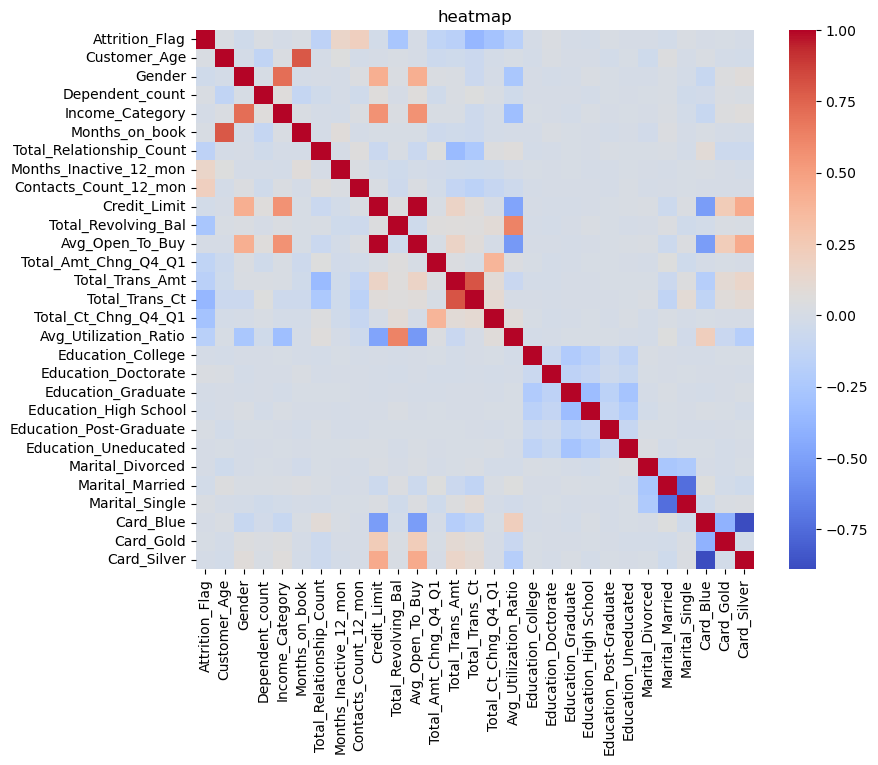

In [8]:
plt.figure(figsize=(9, 7))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('heatmap')
plt.show()

In [9]:
df = df.drop(['Avg_Open_To_Buy'], axis=1)

In [27]:
X_feature = ['Total_Ct_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Amt_Chng_Q4_Q1', 
             'Total_Revolving_Bal', 'Total_Relationship_Count', 'Customer_Age']

In [28]:
X = df.drop('Attrition_Flag', axis=1)
#X = X[X_feature]
y = df['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

In [29]:
rs = RandomOverSampler(random_state=0)
X_resampled, y_resampled = rs.fit_resample(X_train, y_train)

In [30]:
lr_clf = linear_model.LogisticRegression()#class_weight={0: 0.84, 1:0.16})
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
lr_score = accuracy_score(y_test, y_pred_lr)

In [31]:
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
lr_acu_score = accuracy_score(y_test, y_pred_lr).round(3)
#print(f1_score(y_test, y_pred_lr).round(3))
lr_recall_score = recall_score(y_test, y_pred_lr).round(3)
lr_precise_score = precision_score(y_test, y_pred_lr).round(3)

In [32]:
lr_clf.fit(X_resampled, y_resampled)
y_pred_lr = lr_clf.predict(X_test)
lr_acu_score_re = accuracy_score(y_test, y_pred_lr).round(3)
#print(f1_score(y_test, y_pred_lr).round(3))
lr_recall_score_re = recall_score(y_test, y_pred_lr).round(3)
lr_precise_score_re = precision_score(y_test, y_pred_lr).round(3)

In [33]:
lr_metrics = {'accuracy': lr_acu_score, 'recall': lr_recall_score, 'precision': lr_precise_score}
lr_metrics_re = {'accuracy': lr_acu_score_re, 'recall': lr_recall_score_re, 'precision': lr_precise_score_re}
df_lr_metric = pd.DataFrame([lr_metrics, lr_metrics_re], index=['Orignial data', 'Resampled data'])
df_lr_metric

,accuracy,recall,precision
Orignial data,0.89,0.533,0.694
Resampled data,0.82,0.824,0.458


In [34]:
def find_best_k(X_train, y_train, X_test, y_test):
    best_k = 1
    best_score = 0

    for k in range(1, 21):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_test)
        score = accuracy_score(y_test, predictions)
        if score > best_score:
            best_k = k
            best_score = score

    return best_k, best_score

best_k, knn_score = find_best_k(X_train, y_train, X_test, y_test)

In [35]:
svc = SVC()
parameters = {
    'C': [0.1, 1, 10, 100],  
    'kernel': ['rbf', 'linear']  
}

grid_search = GridSearchCV(svc, parameters, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
SVM_score = grid_search.best_score_

In [36]:
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train, y_train)

y_pred_dt = dt_clf.predict(X_test)

decision_tree_score = accuracy_score(y_test, y_pred_dt)

In [37]:
rf_clf = RandomForestClassifier(random_state=0, bootstrap=False, max_depth=30, max_features=0.5, n_estimators=100)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

randomforest_score = accuracy_score(y_test, y_pred_rf)

n_estimators = [50, 100, 200, 300]
max_features = ['auto', 'sqrt', 'log2', 0.2, 0.5]
max_depth = [None, 10, 20, 30]
bootstrap = [True, False]
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'bootstrap': bootstrap
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [38]:
gb_clf = GradientBoostingClassifier(random_state=0,learning_rate=0.1, max_depth=5, max_features='auto'
                                    , n_estimators=300, subsample=0.8)
gb_clf.fit(X_train, y_train)

y_pred_gb = gb_clf.predict(X_test)

gradient_boosting_score = accuracy_score(y_test, y_pred_gb)

learning_rates = [0.1, 0.05, 0.01]
n_estimators = [100, 200, 300]
subsample = [0.8, 1.0]
max_depth = [5, 9]
max_features = ['auto', 'sqrt', 'log2']
param_grid = {
    'learning_rate': learning_rates,
    'n_estimators': n_estimators,
    'subsample': subsample,
    'max_depth': max_depth,
    'max_features': max_features
}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [39]:
estimators = [
    ('RandomForest', rf_clf),
    ('GradientBoosting', gb_clf)
]
st_clf = StackingClassifier(
    estimators=estimators, final_estimator=linear_model.LogisticRegression(max_iter=3000)
)

st_clf.fit(X_train, y_train)
y_pred_st = st_clf.predict(X_test)

stacking_score = accuracy_score(y_test, y_pred_st)

In [40]:
model_scores = pd.DataFrame({
    "KNN": knn_score,
    "SVM": SVM_score,
    "Logistic Regression": lr_score,
    "Decision Tree": decision_tree_score,
    "Random Forest": randomforest_score,
    "Gradient Boosting": gradient_boosting_score,
    "Stacking": stacking_score
}, index=[1])  

model_scores = model_scores.round(3)

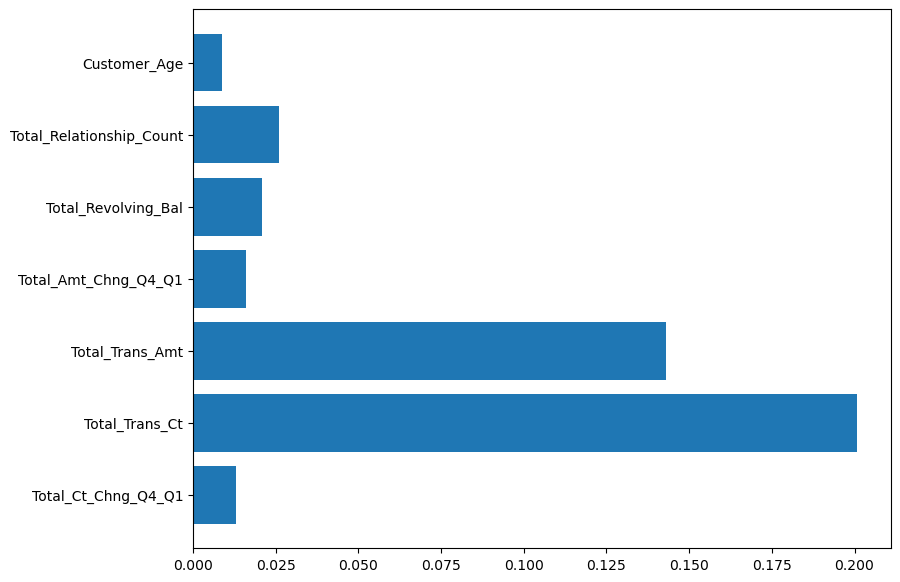

In [41]:
plt.figure(figsize=(9, 7))
pi = permutation_importance(gb_clf, X_test, y_test, scoring=None)
plt.barh(y=range(X_test.columns.size), width=pi.importances_mean, tick_label=X_test.columns)
plt.show()

In [42]:
model_scores.T

,1
KNN,0.928
SVM,0.943
Logistic Regression,0.890
Decision Tree,0.934
Random Forest,0.961
Gradient Boosting,0.966
Stacking,0.967


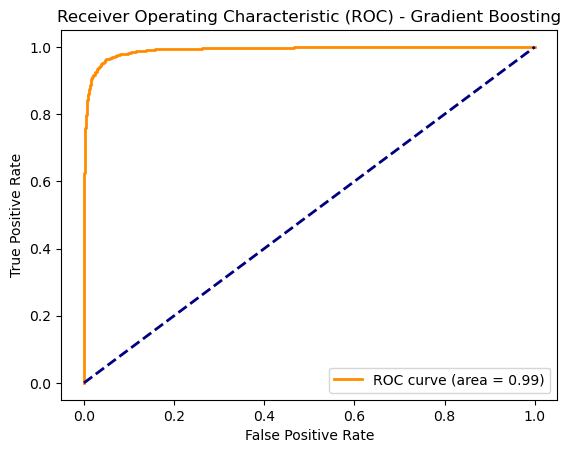

In [25]:
y_pred_prob_gb = gb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()
